# Uplift model

In [1]:
%load_ext autoreload
%autoreload 2

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import warnings
import os


from utils import constants as c
from utils.functions import get_datasets, get_predictions, get_metrics, predict_process, training_process, plot_roc_curve, plot_precision_recall
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

In [3]:
## Read data
path = 'https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/customer_banking/uplifting_model/Dataset/bank-full.csv'
dataset = pd.read_csv(path,sep = ';')

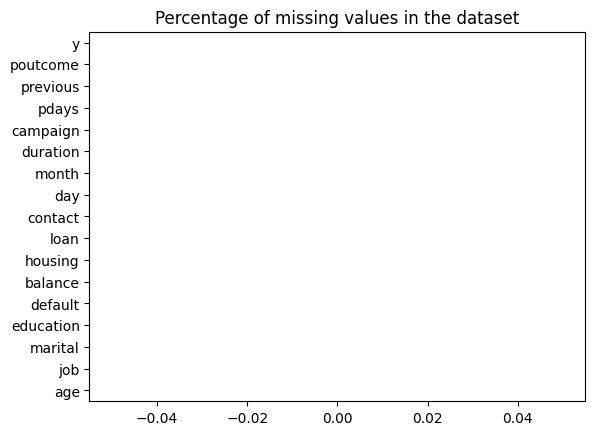

In [4]:
## Percentage of missing values
dataset.isna().mean().plot(kind = 'barh')
plt.title('Percentage of missing values in the dataset')
plt.show()

In [5]:
dataset['poutcome'].value_counts()

poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64

In [6]:
dataset['y'] = dataset['y'].map({'yes':1, 'no':0})

## Uplifting

In [7]:
### Only previous successess
only_success = dataset[dataset['poutcome'] == 'success']
only_failures = dataset[dataset['poutcome'] == 'failure']


In [8]:
CAT_VARS = c.CAT_VARS
VARS = c.VARS

In [109]:
### Model for previous successes
(
    x_train_success, 
    x_val_success, 
    x_test_success, 
    y_train_success, 
    y_val_success, 
    y_test_success 
) = get_datasets(only_success,VARS, 'y')

model = CatBoostClassifier(
    iterations = 20000, 
    depth = 4, 
    learning_rate=0.001,
    loss_function = 'Logloss', 
    verbose = False,
    cat_features = CAT_VARS,
    random_state=123)


model_sucess, y_pred_val_success, y_proba_val_success = training_process(
    model, 
    x_train_success, 
    y_train_success, 
    x_val_success, 
    y_val_success)
y_pred_success, y_proba_success, metrics_success = predict_process(
    model_sucess, 
    0.7, 
    x_test_success, 
    y_test_success)


In [110]:
## Model for failures

(
    x_train_failure, 
    x_val_failure, 
    x_test_failure, 
    y_train_failure, 
    y_val_failure, 
    y_test_failure 
) = get_datasets(only_failures,VARS, 'y')

model_failure = CatBoostClassifier(
    iterations = 20000, 
    depth = 4, 
    learning_rate=0.001,
    loss_function = 'Logloss', 
    verbose = False,
    cat_features = CAT_VARS,
    random_state=123)


model_failure, y_pred_val_failure, y_proba_val_failure = training_process(
    model_failure, 
    x_train_failure, 
    y_train_failure, 
    x_val_failure, 
    y_val_failure)


y_pred_failure, y_proba_failure, metrics_failure = predict_process(
    model_failure, 
    0.3, 
    x_test_failure, 
    y_test_failure)


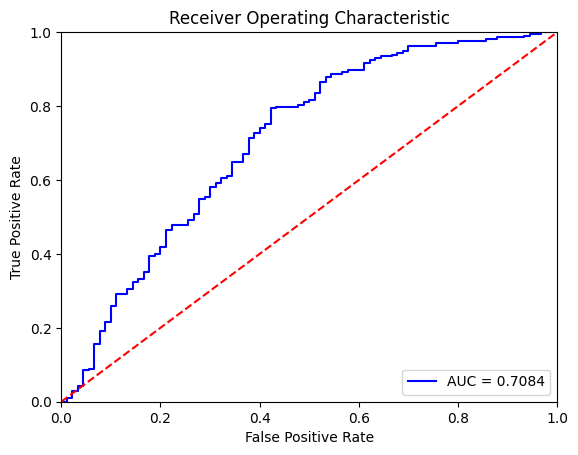

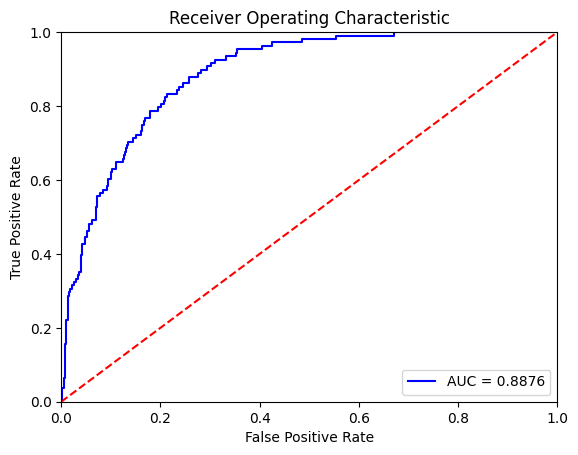

In [79]:
fpr_s, tpr_s, threshold_s = plot_roc_curve(y_test_success, y_proba_success)
fpr_f, tpr_f, threshold_f = plot_roc_curve(y_test_failure, y_proba_failure)

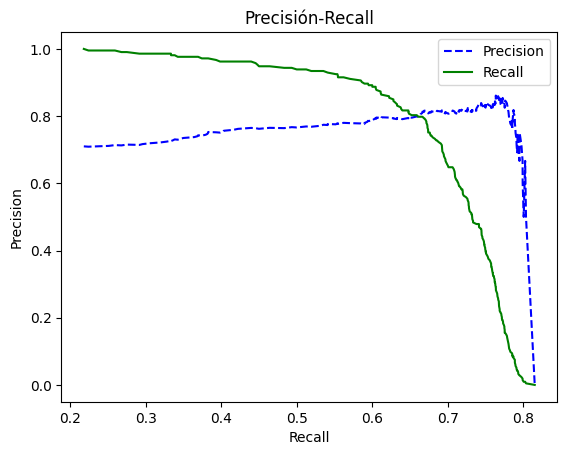

In [107]:
plot_precision_recall(y_test_success, y_proba_success[:,1])

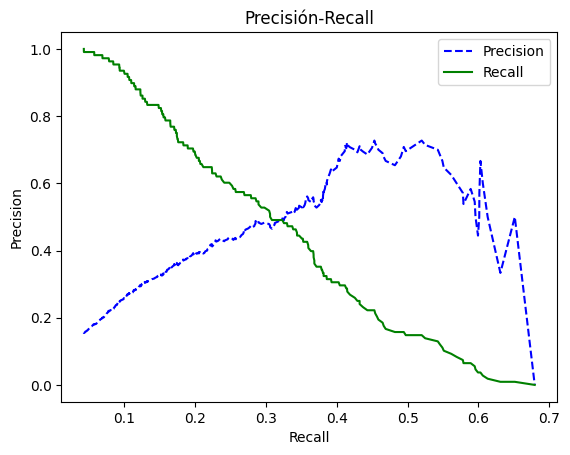

In [108]:
plot_precision_recall(y_test_failure, y_proba_failure[:,1])

In [52]:
x_test_success['pred_model_success'] = y_pred_success
x_test_success['proba_model_success_1'] = y_proba_success[:,1]
x_test_success['pred_model_failure'] = model_failure.predict(x_test_success)
x_test_success['proba_model_failure_1'] = model_failure.predict_proba(x_test_success)[:,1]


In [54]:
x_test_failure['pred_model_failure'] = y_pred_failure
x_test_failure['proba_model_failure_1'] = y_proba_failure[:,1]
x_test_failure['pred_model_success'] = model_sucess.predict(x_test_failure)
x_test_failure['proba_model_success_1'] = model_sucess.predict_proba(x_test_failure)[:,1]

In [111]:
df_unknown = dataset[dataset['poutcome']=='unknown']

In [112]:
df_unknown['pred_model_success'] = np.where(model_sucess.predict(df_unknown[VARS])>0.7,1,0)
df_unknown['proba_model_success'] = model_sucess.predict_proba(df_unknown[VARS])[:,1]
df_unknown['pred_model_failure'] = np.where(model_failure.predict(df_unknown[VARS])>0.3,1,0)
df_unknown['proba_model_failure'] = model_failure.predict_proba(df_unknown[VARS])[:,1]
df_unknown['diff'] = df_unknown['proba_model_success'] - df_unknown['proba_model_failure']

<Axes: xlabel='diff', ylabel='Count'>

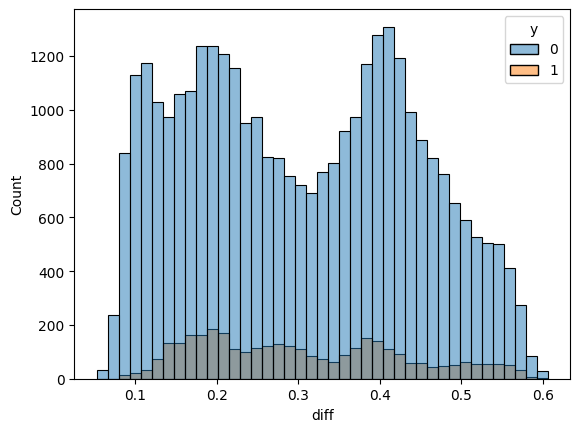

In [113]:
sns.histplot(data = df_unknown, x = 'diff', hue = 'y')

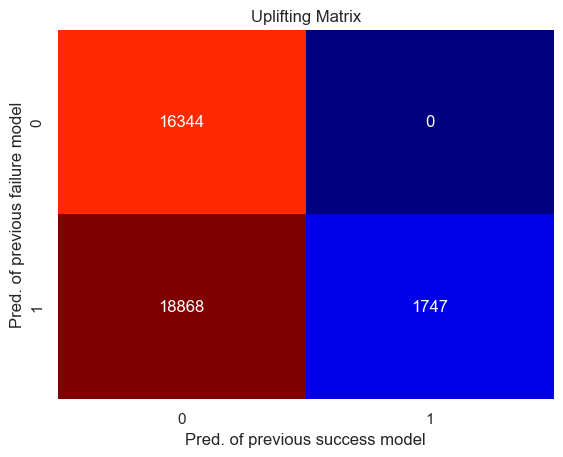

In [135]:

cm = confusion_matrix(df_unknown['pred_model_success'], df_unknown['pred_model_failure'])
ax = sns.heatmap(cm, annot = True, fmt=".0f", cmap="jet", cbar = False)
ax.set(xlabel = 'Pred. of previous success model', ylabel = 'Pred. of previous failure model')
ax.set_title('Uplifting Matrix')
plt.show()
